In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import MNIST, FashionMNIST
from torchvision.datasets import CIFAR10, StanfordCars

import sys
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
sys.path.append('../')

SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Read Dataset

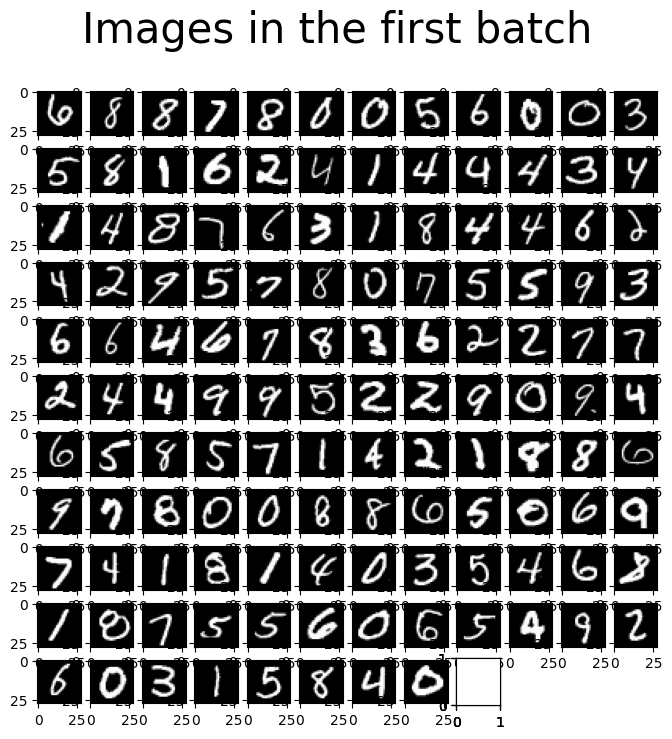

In [2]:
from utils import show_first_batch, transform_data_for_show

dataset = transform_data_for_show(MNIST)
train_dataloader = DataLoader(dataset, batch_size=128, num_workers=0, shuffle=True)
show_first_batch(train_dataloader)

In [3]:
image_channels = next(iter(train_dataloader))[0].size()[1]
image_channels

1

# Some visualization

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [5]:
from diffusion_models.ddpm import CustomDiffusionModel
from reverse_models.unet_1ch.unet import MyUnet



n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02
ddpm = CustomDiffusionModel(MyUnet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

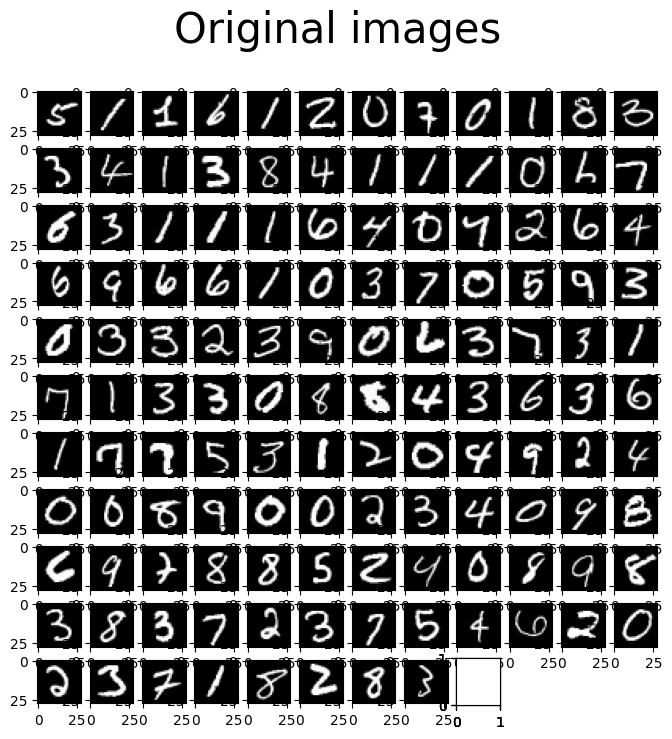

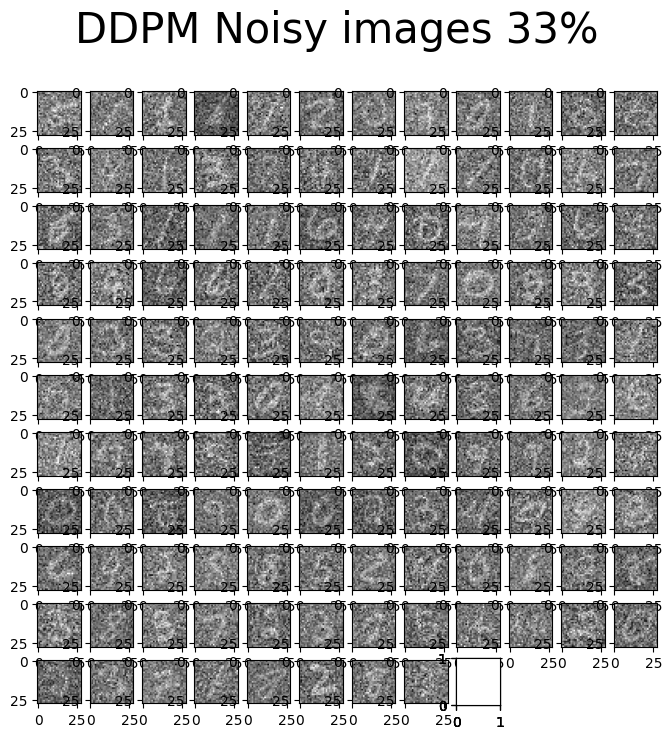

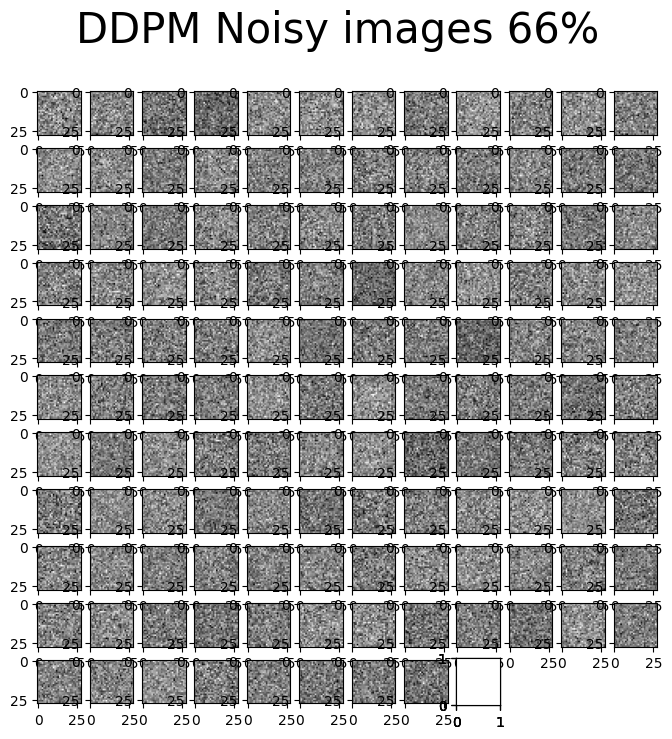

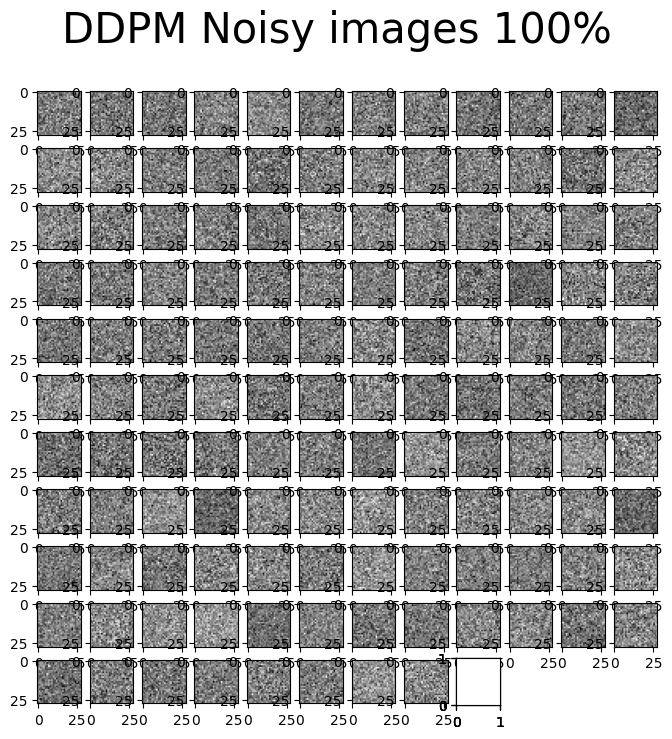

In [6]:
from utils import show_forward

show_forward(ddpm, train_dataloader, device)

# Training

In [ ]:
from utils import training

optimizer = torch.optim.Adam(ddpm.parameters(), lr=0.001)     
training(ddpm, train_dataloader, display=True, n_epochs=40, upset_epoch=1, device=device, optimizer=optimizer, store_path='../model_weights/ddpm_mnist.pt')        

# Testing

In [7]:
store_path = '../model_weights/ddpm_mnist.pt'

best_model = CustomDiffusionModel(MyUnet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")



Model loaded


Generating new images


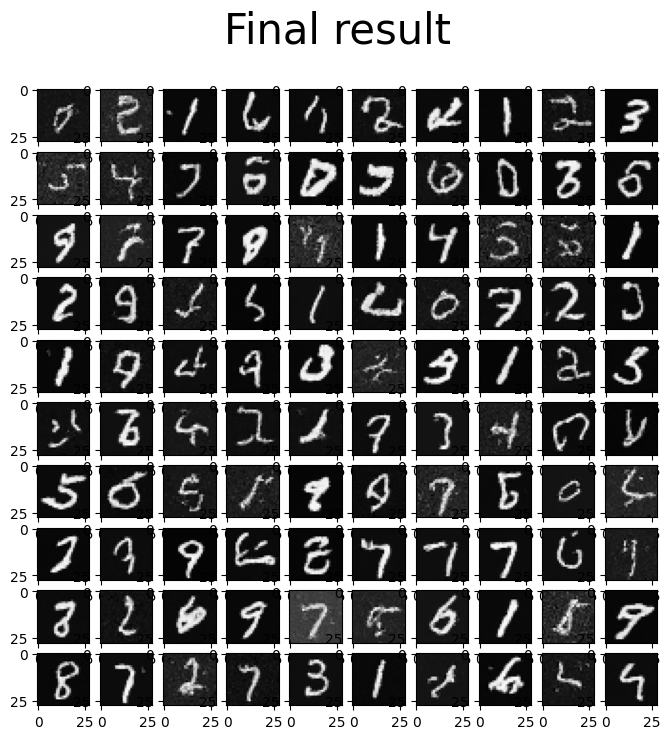

In [8]:
from utils import show_images, generate_new_images

print("Generating new images")
generated = generate_new_images(
        best_model,
        n_samples=100,
        device=device,
        gif_name="../pictures/mnist.gif"
    )
show_images(generated, title="Final result")

In [13]:
from metrics.rate_score import rate_score
from metrics.inception_score import inception_score


print('bits_per_pixel = {}, N = 100'.format(rate_score(generated)))
if image_channels == 3:
    print('inception_score = {}'.format(inception_score(generated, device=device)))

bits_per_pixel = 24.314369201660156, N = 100
